# Advanced Classification - Gradient Boosting RFE
- Solve the classification task defined in Module 1 (or define new ones) with the
other classification methods analyzed during the course: Logistic Regression,
Support Vector Machines, Neural Networks, Ensemble Methods, Gradient Boosting
Machines.
- Always perform hyper-parameter tuning phases and justify your choices (which
are the best parameters? which parameters did you test and why?).
- Evaluate each classifier with the techniques presented in DM1: accuracy (or
precision, recall, F1-score etc), ROC curve (or lift, precision-recall etc).
- Besides the numerical evaluation draw your conclusions about the various
classifiers (e.g. for Neural Networks: what are the parameter sets or the
convergence criteria which avoid overfitting? For Ensemble classifiers how the
number of base models impact the classification performance? What is revealing
the feature importance of Random Forests?)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

## Data Preprocessing

In [2]:
# reading the clean dataset with only features selected with filter approaches
# the data is also already normalized (min-max) and cubic-transformed
df_all = pd.read_csv('data/data_RFE_advClass_emotion.csv')
print(df_all.shape)
df_all.head()

(2452, 16)


,mfcc_sum,mfcc_q95,sc_q50,zc_sum_w1,mfcc_q99_w1,mfcc_min_w2,stft_sum_w2,zc_sum_w3,mfcc_q05_w3,mfcc_q99_w3,mfcc_kur_w3,sc_kur_w3,mfcc_sum_w4,sc_std_w4,stft_sum_w4,emotion
0,0.591481,0.447466,0.927656,0.062556,0.483503,0.299631,0.466630,0.224149,0.801812,0.833184,0.481993,0.533887,0.597521,0.268862,0.514047,neutral
1,0.592678,0.470939,0.799551,0.149082,0.489737,0.290148,0.519341,0.235869,0.852725,0.839149,0.449225,0.552003,0.555675,0.268475,0.483277,neutral
2,0.602877,0.380469,0.911578,0.149221,0.491881,0.301450,0.483079,0.219039,0.820192,0.845064,0.451288,0.586855,0.565339,0.299826,0.472904,neutral
3,0.635597,0.409318,0.841966,0.101420,0.630466,0.301954,0.505780,0.211274,0.838101,0.760320,0.441262,0.554301,0.667524,0.247404,0.445061,neutral
4,0.523167,0.548329,0.733857,0.055005,0.507731,0.216527,0.510112,0.257198,0.868720,0.772112,0.365163,0.544002,0.570613,0.299318,0.514943,calm


In [3]:
# TRAIN and TEST datasets split (and labels)
targ = 'emotion'
labels = df_all.pop(targ)
df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

# vars to encode
#cat_vars = list(df_all.loc[:,'vocal_channel':'sex'].columns)

# one hot encoding of train df_train and df_test
#df_train = pd.get_dummies(df_train, columns = cat_vars)
#df_test = pd.get_dummies(df_test, columns = cat_vars)

# Label Encoder
le = LabelEncoder()
labels = le.fit_transform(labels)
label_encoder_name_mapping = dict(zip(le.classes_,
                                         le.transform(le.classes_)))
print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

# splitting the labels in train and test
labels_train, labels_test = labels[:1828], labels[1828:]
df_train.insert(0,str(targ),labels_train)
df_test.insert(0,str(targ),labels_test)

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [4]:
# checking the shapes
print('train and test dfs shape: ', df_train.shape, df_test.shape)
print('train and test labels shape: ', labels_train.shape, labels_test.shape)
df_train.head()

train and test dfs shape:  (1828, 16) (624, 16)
train and test labels shape:  (1828,) (624,)


,emotion,mfcc_sum,mfcc_q95,sc_q50,zc_sum_w1,mfcc_q99_w1,mfcc_min_w2,stft_sum_w2,zc_sum_w3,mfcc_q05_w3,mfcc_q99_w3,mfcc_kur_w3,sc_kur_w3,mfcc_sum_w4,sc_std_w4,stft_sum_w4
0,5,0.591481,0.447466,0.927656,0.062556,0.483503,0.299631,0.466630,0.224149,0.801812,0.833184,0.481993,0.533887,0.597521,0.268862,0.514047
1,5,0.592678,0.470939,0.799551,0.149082,0.489737,0.290148,0.519341,0.235869,0.852725,0.839149,0.449225,0.552003,0.555675,0.268475,0.483277
2,5,0.602877,0.380469,0.911578,0.149221,0.491881,0.301450,0.483079,0.219039,0.820192,0.845064,0.451288,0.586855,0.565339,0.299826,0.472904
3,5,0.635597,0.409318,0.841966,0.101420,0.630466,0.301954,0.505780,0.211274,0.838101,0.760320,0.441262,0.554301,0.667524,0.247404,0.445061
4,1,0.523167,0.548329,0.733857,0.055005,0.507731,0.216527,0.510112,0.257198,0.868720,0.772112,0.365163,0.544002,0.570613,0.299318,0.514943


In [5]:
# if we want to oversample the data
def apply_ADASYN(X, y):
    # oversampling the minority class for balanced learning
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(random_state = 42)
    X, y = ada.fit_resample(X, y)
    print('resampled training set: ', X.shape, y.shape)
    print('target var. class frequencies:')
    print(Counter(y))
    return X, y

In [6]:
# converting df_train and df_test into np matrices and arrays
X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

# shuffling train and val concatenation to remove potential pattern bias
X, y  = shuffle(X, y, random_state=42)

# adasyn oversampling
#X, y = apply_ADASYN(X,y)

# split train/val = 80/20
split_idx = df_train.shape[0]-int(df_train.shape[0]*0.2)
X_train, X_val = X[:split_idx,:], X[split_idx:,:]
y_train, y_val = y[:split_idx], y[split_idx:]

print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_val: ', X_val.shape, 'y_val: ', y_val.shape)
print()

print('target variable classes frequencies:')
print()
print('training set: ',Counter(y_train))
print('validation set: ',Counter(y_val))
print('test set: ',Counter(labels_test))

X_train:  (1463, 15) y_train:  (1463,)
X_val:  (365, 15) y_val:  (365,)

target variable classes frequencies:

training set:  Counter({0: 233, 1: 230, 3: 220, 4: 220, 6: 213, 2: 116, 5: 116, 7: 115})
validation set:  Counter({6: 67, 4: 60, 3: 60, 1: 50, 0: 47, 7: 29, 2: 28, 5: 24})
test set:  Counter({1: 96, 4: 96, 6: 96, 0: 96, 3: 96, 5: 48, 2: 48, 7: 48})


In [7]:
np.random.seed(42)  # for reproducibility

#### Libs for Gradient Boosting 

In [8]:
# classification
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# regression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Classification w/ Gradient Boosting

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

In [10]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [11]:
# all the classes of the target variable
classes = df_train[targ].unique()
classes

array([5, 1, 4, 6, 0, 3, 2, 7])

## Hyperparameter Tuning

In [12]:
# return best estimator from gridsearch
def rs_best_estimator(clf, param_grid, X, y, cv=5):
    rs = RandomizedSearchCV(clf, param_distributions=param_grid, cv=cv, scoring = 'accuracy')
    rs.fit(X, y)
    print(f'best estimator: {rs.best_estimator_}')
    print(f'best score: {rs.best_score_}')
    print(f'best parameters: {rs.best_params_}')       
    return rs

In [13]:
# params to possibly tune
#print(gb_c.get_params().keys())
#print(hgb_c.get_params().keys())
#print(xgb_c.get_params().keys())
#print(lgbm_c.get_params().keys())

### Normal GBoost tuning

In [14]:
#n_estimators = [x for x in range(10,100,10)]
#param_grid1 = dict(n_estimators=n_estimators)
#gb_c = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8, random_state=42)
#
#rs_results_gb_c = rs_best_estimator(gb_c, param_grid1, X, y)

In [15]:
#max_depth = [x for x in range(3,8)]
#min_samples_split = [20,50,100]
#param_grid2 = dict(max_depth=max_depth, min_samples_split=min_samples_split)
#gb_c = GradientBoostingClassifier(learning_rate=0.3, n_estimators=90, max_features='sqrt', subsample=0.8, random_state=42)
#
#rs_results_gb_c = rs_best_estimator(gb_c, param_grid2, X, y)

In [16]:
#min_samples_split = [40,50,60,70]
#min_samples_leaf = [x for x in range(4,9)]
#param_grid3 = dict(min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
#gb_c = GradientBoostingClassifier(learning_rate=0.3, n_estimators=90, max_features='sqrt', max_depth = 7, subsample=0.8, random_state=42)
#
#rs_results_gb_c = rs_best_estimator(gb_c, param_grid3, X, y)

In [17]:
#max_features = [f for f in range(7,20,2)]
#param_grid4 = dict(max_features=max_features)
#gb_c = GradientBoostingClassifier(learning_rate=0.3, n_estimators=90, max_depth = 7, min_samples_split=40,
#                                  min_samples_leaf=8, subsample=0.8, random_state=42)
#
#rs_results_gb_c = rs_best_estimator(gb_c, param_grid4, X, y)

In [18]:
#subsample = [0.6,0.7,0.75,0.8,0.85,0.9]
#param_grid5 = dict(subsample=subsample)
#gb_c = GradientBoostingClassifier(learning_rate=0.3, n_estimators=90, max_depth = 7, min_samples_split=40,
#                                  min_samples_leaf=8, max_features=11, random_state=42)
#
#rs_results_gb_c = rs_best_estimator(gb_c, param_grid5, X, y)

- best score: 0.7164444444444444 best parameters: {'n_estimators': 90}
- best score: 0.7373333333333333 best parameters: {'min_samples_split': 50, 'max_depth': 7}
- best score: 0.7573333333333333 best parameters: {'min_samples_split': 40, 'min_samples_leaf': 8, 'max_features':11}
- best score: 0.7617777777777778 best parameters: {'subsample': 0.9}

In [19]:
# now we lower the learning rate and the number of estimators to see if the model gets better -> NO
#l_rates = [0.3,0.4]
#for i,lr in enumerate(l_rates):
#    tuned_gb_c = GradientBoostingClassifier(learning_rate=lr, n_estimators=90, max_depth = 7, min_samples_split=40,
#                                        min_samples_leaf=8, max_features=11, subsample= 0.9, random_state=42)
#
#    sk_folds = StratifiedKFold(n_splits = 5)
#
#    scores = cross_val_score(tuned_gb_c, X, y, cv = sk_folds)
#    print(f'Learning Rate: {l_rates[i]}')
#    print()
#    print("Cross Validation Scores: ", scores)
#    print("Average CV Score: ", np.mean(scores))
#    print("Number of CV Scores used in Average: ", len(scores))
#    print()

Lower -> worse!

Learning Rate: 0.3

    Cross Validation Scores:  [0.75333333 0.71111111 0.79333333 0.82       0.73111111]
    Average CV Score:  0.7617777777777778
    Number of CV Scores used in Average:  5

Learning Rate: 0.4

    Cross Validation Scores:  [0.75333333 0.72222222 0.77333333 0.81111111 0.73333333]
    Average CV Score:  0.7586666666666666
    Number of CV Scores used in Average:  5


### Hist GBoost tuning

In [20]:
#l2_regularization = [0.01,0.05,0.1,0.2]
#param_grid6 = dict(l2_regularization=l2_regularization)
#hgb_c = HistGradientBoostingClassifier(loss = 'categorical_crossentropy', learning_rate=0.3, 
#                                        max_depth = 7, min_samples_leaf=8, random_state=42)
#
#rs_results_hgb_c = rs_best_estimator(hgb_c, param_grid6, X, y)

- best score: 0.7555555555555555 best parameters: {'l2_regularization': 0.01}

### XGBoost tuning

In [21]:
#gamma = [0, 1, 10]
#objective = ['multi:softprob','multi:softmax']
#param_grid7 = dict(gamma = gamma, objective = objective)
#xgb_c = XGBClassifier(learning_rate=0.3, n_estimators=90, max_depth = 7, min_samples_split=40,
#                        min_samples_leaf=8, max_features=11, reg_lambda = 0.01,
#                        tree_method='exact', random_state=42)
#
#rs_results_xgb_c = rs_best_estimator(xgb_c, param_grid7, X, y)

- best score: 0.728 best parameters: {'objective': 'multi:softprob', 'gamma': 0}

## Testing the tuned Gradient Boosting variants

In [22]:
warnings.filterwarnings('ignore')

In [23]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, plot_precision_recall_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

Accuracy: 0.38461538461538464

F1-score: [0.54222222 0.47959184 0.30927835 0.36904762 0.3125     0.39252336
 0.29126214 0.2247191 ]

              precision    recall  f1-score   support

       angry       0.47      0.64      0.54        96
        calm       0.47      0.49      0.48        96
     disgust       0.31      0.31      0.31        48
     fearful       0.43      0.32      0.37        96
       happy       0.39      0.26      0.31        96
     neutral       0.36      0.44      0.39        48
         sad       0.27      0.31      0.29        96
   surprised       0.24      0.21      0.22        48

    accuracy                           0.38       624
   macro avg       0.37      0.37      0.37       624
weighted avg       0.38      0.38      0.38       624



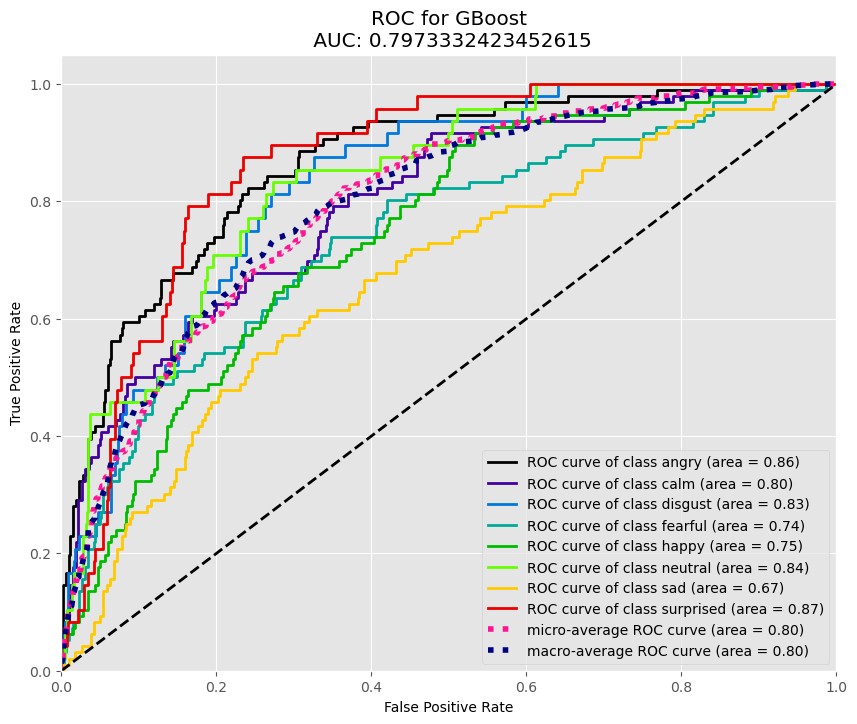

In [24]:
gb_c = GradientBoostingClassifier(learning_rate=0.3, n_estimators=90, max_depth = 7, min_samples_split=40,
                                  min_samples_leaf=8, max_features=11, random_state=42)
gb_c = gb_c.fit(X,y)
y_hat_gb_c = gb_c.predict(X_test).ravel()
acc_score_gb_c = accuracy_score(y_test, y_hat_gb_c)
f1_gb_c = f1_score(y_test, y_hat_gb_c, average=None)

print(f'Accuracy: {acc_score_gb_c}')
print()
print(f'F1-score: {f1_gb_c}')
print()
print(classification_report(y_test, y_hat_gb_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = gb_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, gb_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for GBoost\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()


Text(0.5, 1.0, "GBoost's Permutation Importance of the features")

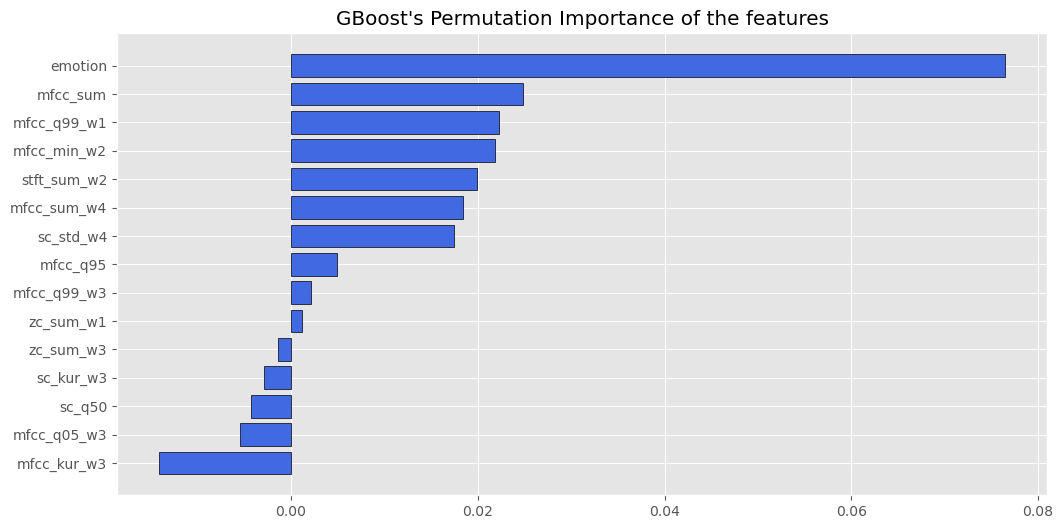

In [25]:
# plotting permutation importance of the top features
perm_importance = permutation_importance(gb_c, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'GBoost\'s Permutation Importance of the features')

### Hist GBoost

Accuracy: 0.3814102564102564

F1-score: [0.57657658 0.43850267 0.32142857 0.3255814  0.2875     0.36893204
 0.31527094 0.29213483]

              precision    recall  f1-score   support

       angry       0.51      0.67      0.58        96
        calm       0.45      0.43      0.44        96
     disgust       0.28      0.38      0.32        48
     fearful       0.37      0.29      0.33        96
       happy       0.36      0.24      0.29        96
     neutral       0.35      0.40      0.37        48
         sad       0.30      0.33      0.32        96
   surprised       0.32      0.27      0.29        48

    accuracy                           0.38       624
   macro avg       0.37      0.38      0.37       624
weighted avg       0.38      0.38      0.37       624



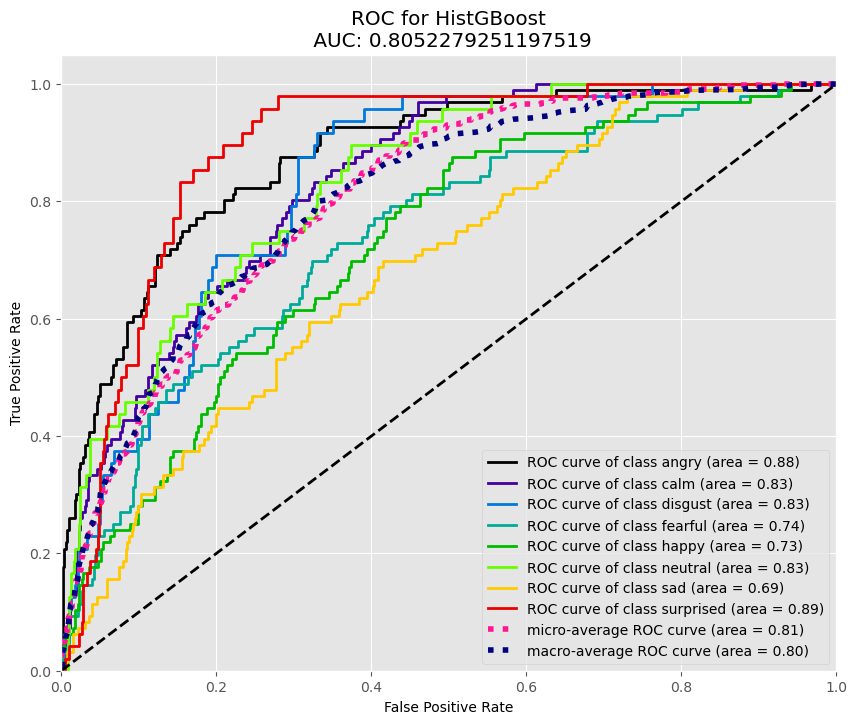

In [26]:
hgb_c = HistGradientBoostingClassifier(loss = 'categorical_crossentropy', learning_rate=0.3, 
                                        max_depth = 7, min_samples_leaf=8,
                                        l2_regularization=0.01, random_state=42)
hgb_c = hgb_c.fit(X,y)
y_hat_hgb_c = hgb_c.predict(X_test).ravel()
acc_score_hgb_c = accuracy_score(y_test, y_hat_hgb_c)
f1_hgb_c = f1_score(y_test, y_hat_hgb_c, average=None)

print(f'Accuracy: {acc_score_hgb_c}')
print()
print(f'F1-score: {f1_hgb_c}')
print()
print(classification_report(y_test, y_hat_hgb_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = hgb_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, hgb_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for HistGBoost\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()


Text(0.5, 1.0, "HistGBoost's Permutation Importance of the features")

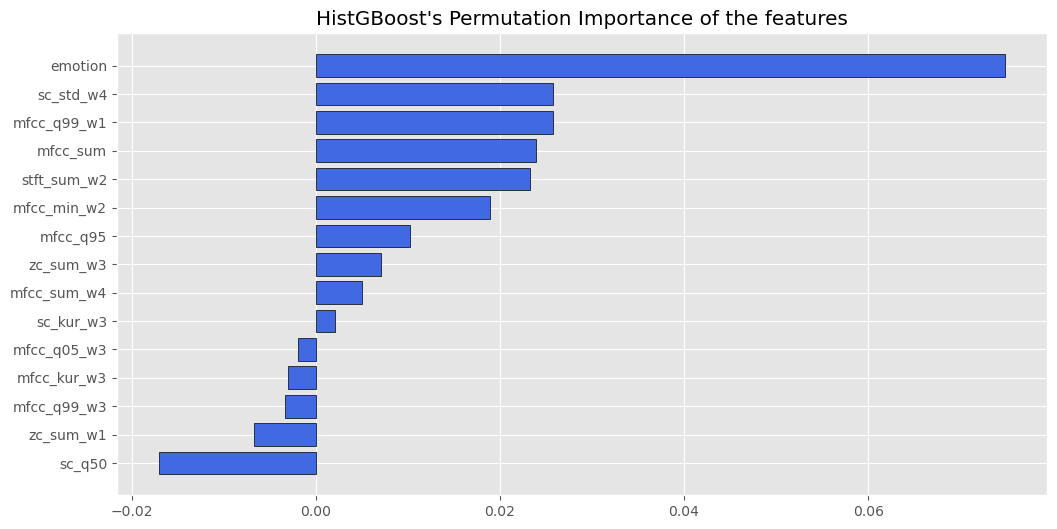

In [27]:
# plotting permutation importance of the top features
perm_importance = permutation_importance(hgb_c, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'HistGBoost\'s Permutation Importance of the features')

### XGBoost

Accuracy: 0.38461538461538464

F1-score: [0.53811659 0.45502646 0.36       0.3583815  0.25       0.39285714
 0.33497537 0.27272727]

              precision    recall  f1-score   support

       angry       0.47      0.62      0.54        96
        calm       0.46      0.45      0.46        96
     disgust       0.35      0.38      0.36        48
     fearful       0.40      0.32      0.36        96
       happy       0.31      0.21      0.25        96
     neutral       0.34      0.46      0.39        48
         sad       0.32      0.35      0.33        96
   surprised       0.30      0.25      0.27        48

    accuracy                           0.38       624
   macro avg       0.37      0.38      0.37       624
weighted avg       0.38      0.38      0.38       624



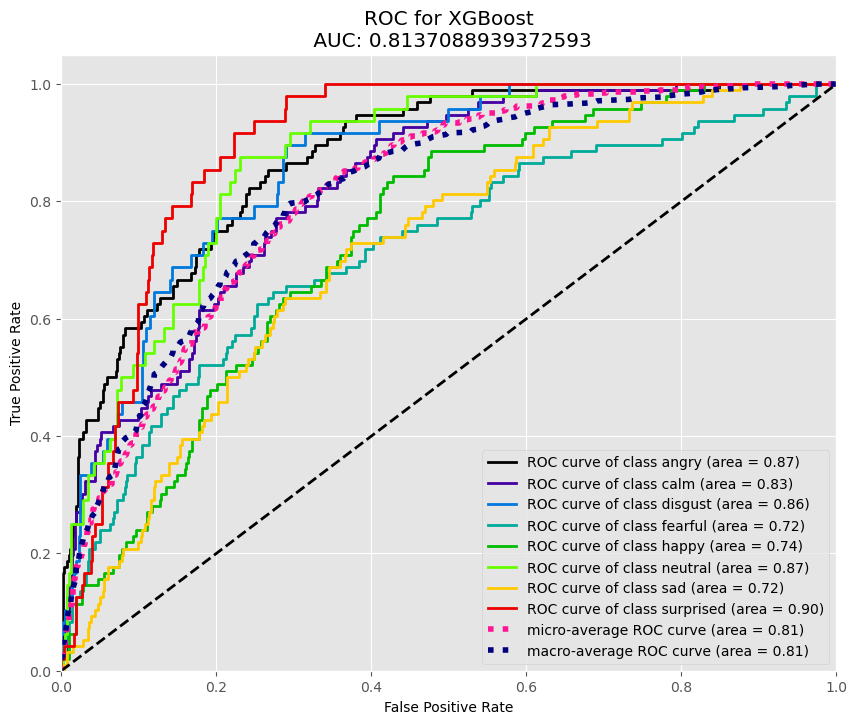

In [28]:
xgb_c = XGBClassifier(objective='multi:softprob', # multi:softmax
                        learning_rate=0.3, n_estimators=90, max_depth = 7, 
                        reg_lambda = 0.01, gamma = 0.2,
                        tree_method='exact', random_state=42)
xgb_c = xgb_c.fit(X,y)
y_hat_xgb_c = xgb_c.predict(X_test).ravel()
acc_score_xgb_c = accuracy_score(y_test, y_hat_xgb_c)
f1_xgb_c = f1_score(y_test, y_hat_xgb_c, average=None)

print(f'Accuracy: {acc_score_xgb_c}')
print()
print(f'F1-score: {f1_xgb_c}')
print()
print(classification_report(y_test, y_hat_xgb_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = xgb_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, xgb_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for XGBoost\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

Text(0.5, 1.0, "XGBoost's Permutation Importance of the features")

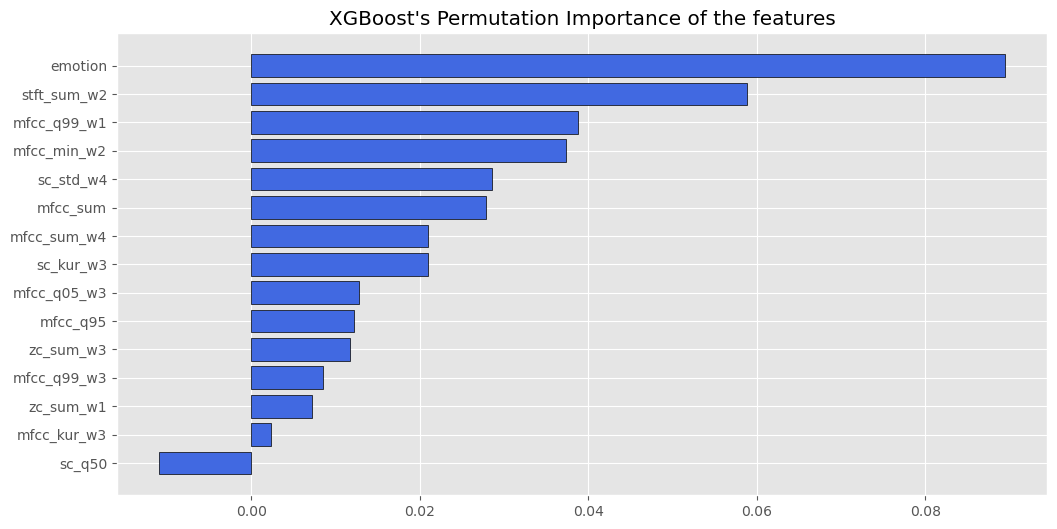

In [29]:
# plotting permutation importance of the top features
perm_importance = permutation_importance(xgb_c, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'XGBoost\'s Permutation Importance of the features')

### Light GBM

Accuracy: 0.391025641025641

F1-score: [0.57009346 0.4742268  0.28865979 0.33707865 0.24418605 0.43181818
 0.33333333 0.37894737]

              precision    recall  f1-score   support

       angry       0.52      0.64      0.57        96
        calm       0.47      0.48      0.47        96
     disgust       0.29      0.29      0.29        48
     fearful       0.37      0.31      0.34        96
       happy       0.28      0.22      0.24        96
     neutral       0.47      0.40      0.43        48
         sad       0.31      0.36      0.33        96
   surprised       0.38      0.38      0.38        48

    accuracy                           0.39       624
   macro avg       0.38      0.38      0.38       624
weighted avg       0.39      0.39      0.39       624



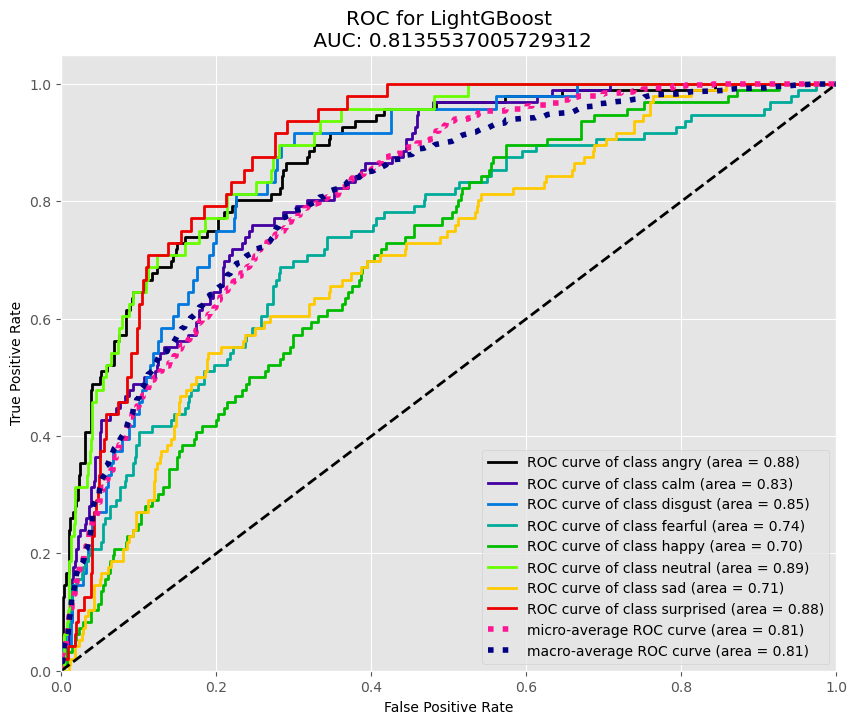

In [30]:
# we won't use this variant since we already tested the other
lgbm_c = LGBMClassifier(boosting_type='goss', max_depth=-1, num_leaves=31, n_estimators=90, objective='binary',
                        reg_lambda=0.01, random_state=42)

lgbm_c = lgbm_c.fit(X,y)
y_hat_lgbm_c = lgbm_c.predict(X_test).ravel()
acc_score_lgbm_c = accuracy_score(y_test, y_hat_lgbm_c)
f1_lgbm_c = f1_score(y_test, y_hat_lgbm_c, average=None)

print(f'Accuracy: {acc_score_lgbm_c}')
print()
print(f'F1-score: {f1_lgbm_c}')
print()
print(classification_report(y_test, y_hat_lgbm_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = lgbm_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, lgbm_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for LightGBoost\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

Text(0.5, 1.0, "LightGBoost's Permutation Importance of the features")

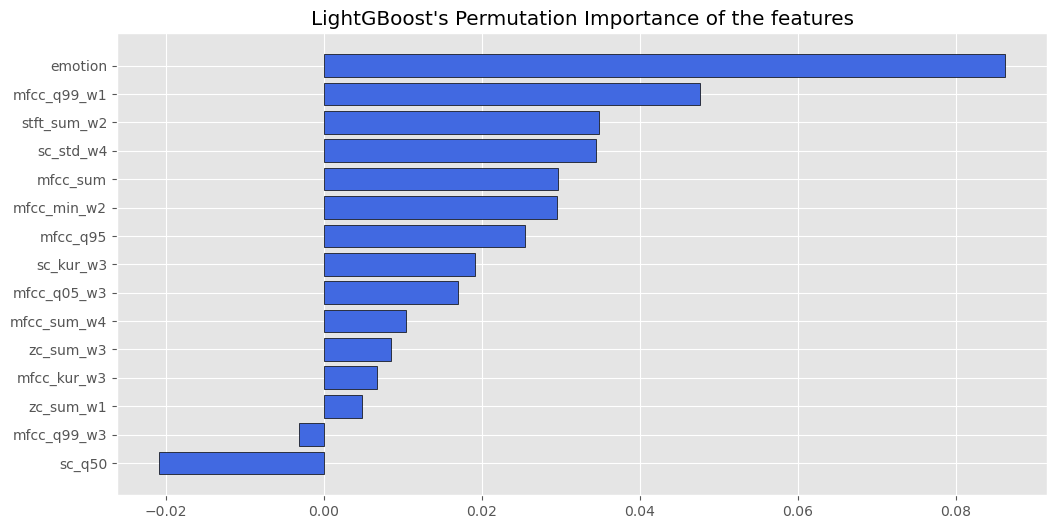

In [31]:
# plotting permutation importance of the top features
perm_importance = permutation_importance(lgbm_c, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'LightGBoost\'s Permutation Importance of the features')

# Advanced Regression - Gradient Boosting UFS

In [32]:
# df used for regression
df_all_r = pd.read_csv('data/data_UFS_advReg_zcsum.csv')
print(df_all_r.shape)
df_all_r.head()

(2452, 16)


,mfcc_max,mfcc_q25,mfcc_q50,mfcc_q99,zc_sum_w1,mfcc_std_w1,mfcc_q25_w1,zc_sum_w2,sc_sum_w2,zc_sum_w3,mfcc_q99_w3,sc_sum_w3,zc_sum_w4,mfcc_std_w4,mfcc_q25_w4,zc_sum
0,0.717587,0.896695,0.479183,0.752627,0.062556,0.933467,0.679413,0.224991,0.210342,0.224149,0.833184,0.307510,0.448805,0.866067,0.653604,0.129522
1,0.598435,0.862466,0.479183,0.729264,0.149082,0.819130,0.679413,0.198031,0.226723,0.235869,0.839149,0.255697,0.396224,0.898993,0.632088,0.148238
2,0.667726,0.896088,0.479183,0.801084,0.149221,0.821121,0.701664,0.130543,0.250507,0.219039,0.845064,0.222941,0.361620,0.903513,0.611607,0.104711
3,0.584642,0.892183,0.506330,0.731318,0.101420,0.800603,0.654612,0.154487,0.291251,0.211274,0.760320,0.227556,0.492813,0.785652,0.614810,0.138251
4,0.676841,0.852104,0.483519,0.747265,0.055005,0.903958,0.679413,0.196080,0.240252,0.257198,0.772112,0.207254,0.461552,0.840194,0.636019,0.122601


In [33]:
# TRAIN and TEST datasets split (and labels)
targ = 'zc_sum'
labels = df_all_r.pop(targ)
df_train, df_test = df_all_r.loc[:1827,:], df_all_r.loc[1828:,:]

# vars to encode
try:
    cat_vars = list(df_all_r.loc[:,'vocal_channel':'sex'].columns)
    # one hot encoding of train df_train and df_test
    df_train = pd.get_dummies(df_train, columns = cat_vars)
    df_test = pd.get_dummies(df_test, columns = cat_vars)   
except:
    pass

# splitting the labels in train and test
labels_train, labels_test = labels[:1828], labels[1828:]
df_train.insert(0,str(targ),labels_train)
df_test.insert(0,str(targ),labels_test)

In [34]:
# checking the shapes
print('train and test dfs shape: ', df_train.shape, df_test.shape)
print('train and test labels shape: ', labels_train.shape, labels_test.shape)
df_train.head()

train and test dfs shape:  (1828, 16) (624, 16)
train and test labels shape:  (1828,) (624,)


,zc_sum,mfcc_max,mfcc_q25,mfcc_q50,mfcc_q99,zc_sum_w1,mfcc_std_w1,mfcc_q25_w1,zc_sum_w2,sc_sum_w2,zc_sum_w3,mfcc_q99_w3,sc_sum_w3,zc_sum_w4,mfcc_std_w4,mfcc_q25_w4
0,0.129522,0.717587,0.896695,0.479183,0.752627,0.062556,0.933467,0.679413,0.224991,0.210342,0.224149,0.833184,0.307510,0.448805,0.866067,0.653604
1,0.148238,0.598435,0.862466,0.479183,0.729264,0.149082,0.819130,0.679413,0.198031,0.226723,0.235869,0.839149,0.255697,0.396224,0.898993,0.632088
2,0.104711,0.667726,0.896088,0.479183,0.801084,0.149221,0.821121,0.701664,0.130543,0.250507,0.219039,0.845064,0.222941,0.361620,0.903513,0.611607
3,0.138251,0.584642,0.892183,0.506330,0.731318,0.101420,0.800603,0.654612,0.154487,0.291251,0.211274,0.760320,0.227556,0.492813,0.785652,0.614810
4,0.122601,0.676841,0.852104,0.483519,0.747265,0.055005,0.903958,0.679413,0.196080,0.240252,0.257198,0.772112,0.207254,0.461552,0.840194,0.636019


In [35]:
# converting df_train and df_test into np matrices and arrays
X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

# shuffling train and val concatenation to remove potential pattern bias
X, y  = shuffle(X, y, random_state=42)

# split train/val = 80/20
split_idx = df_train.shape[0]-int(df_train.shape[0]*0.2)
X_train, X_val = X[:split_idx,:], X[split_idx:,:]
y_train, y_val = y[:split_idx], y[split_idx:]

print('X_train: ', X_train.shape, '\ty_train: ', y_train.shape)
print('X_val: ', X_val.shape, '\ty_val: ', y_val.shape)
print()

print(f'target variable: {targ}')
print()
print(f'training set:\n\tmean = {np.mean(y_train)}\n\tstd = {np.std(y_train)}')
print()
print(f'validation set:\n\tmean = {np.mean(y_val)}\n\tstd = {np.std(y_val)}')
print()
print(f'test set:\n\tmean = {np.mean(y_test)}\n\tstd = {np.std(y_test)}')

X_train:  (1463, 15) 	y_train:  (1463,)
X_val:  (365, 15) 	y_val:  (365,)

target variable: zc_sum

training set:
	mean = 0.3226886563544897
	std = 0.14656531914747928

validation set:
	mean = 0.31990696652259903
	std = 0.15530963447510865

test set:
	mean = 0.3177794127729249
	std = 0.1307509508324391


In [36]:
np.random.seed(42)  # for reproducibility

#### Libs for Gradient Boosting 

In [37]:
# regression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Regression w/ Gradient Boosting

In [38]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

In [39]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [40]:
# number of unique values of the target variable
vals = df_train[targ].value_counts()
len(vals)

1682

## Hyperparameter Tuning

In [41]:
# return best estimator from gridsearch
def rs_best_regression(clf, param_grid, X, y, cv=5):
    rs = RandomizedSearchCV(clf, param_distributions=param_grid, cv=cv, scoring = 'neg_mean_absolute_error')
    rs.fit(X, y)
    print(f'best estimator: {rs.best_estimator_}')
    print(f'best score: {rs.best_score_}')
    print(f'best parameters: {rs.best_params_}')       
    return rs

### Normal GBoost tuning

In [42]:
#n_estimators = [x for x in range(10,150,10)]
#param_grid1 = dict(n_estimators=n_estimators)
#l_rates = [0.05,0.1,0.2]
#for lr in l_rates:
#    print(f'best for lr = {lr}')
#    gb_r = GradientBoostingRegressor(learning_rate=lr, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8, random_state=42)
#
#    rs_results_gb_r = rs_best_regression(gb_r, param_grid1, X, y)

- learning rate = [0.05,0.1,0.2]
    - best score: best score: -0.031068541861095082 best parameters: {'n_estimators': 130}
    - best score: best score: -0.02428063098142213 best parameters: {'n_estimators': 140}
    - best score: best score: -0.024740318730422522 best parameters: {'n_estimators': 130} better, less estimators

In [43]:
#max_depth = [x for x in range(3,10)]
#min_samples_split = [70,85,100]
#param_grid2 = dict(max_depth=max_depth, min_samples_split=min_samples_split)
#gb_r = GradientBoostingRegressor(learning_rate=0.1, n_estimators=130, max_features='sqrt', subsample=0.8, random_state=42)
#
#rs_results_gb_r = rs_best_regression(gb_r, param_grid2, X, y)

- best score: -0.021380314733274713 best parameters: {'min_samples_split': 100, 'max_depth': 7}

In [44]:
#min_samples_split = [s for s in range(70,211,20)]
#min_samples_leaf = [l for l in range(4,21,2)]
#param_grid3 = dict(min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
#gb_r = GradientBoostingRegressor(learning_rate=0.1, n_estimators=130, max_features='sqrt', max_depth = 7, subsample=0.8, random_state=42)
#
#rs_results_gb_r = rs_best_regression(gb_r, param_grid3, X, y)

- best score: -0.0214666803362347 best parameters: {'min_samples_split': 170, 'min_samples_leaf': 6}

In [45]:
#max_features = [f for f in range(7,23,2)]
#param_grid4 = dict(max_features=max_features)
#gb_r = GradientBoostingRegressor(learning_rate=0.1, n_estimators=130, max_depth = 7, min_samples_split=170,
#                                  min_samples_leaf=6, subsample=0.8, random_state=42)
#
#rs_results_gb_r = rs_best_regression(gb_r, param_grid4, X, y)

- best score: -0.01769018006722203 best parameters: {'max_features': 19}

In [46]:
#subsample = [0.6,0.7,0.75,0.8,0.85,0.9]
#param_grid5 = dict(subsample=subsample)
#gb_r = GradientBoostingRegressor(learning_rate=0.1, n_estimators=130, max_depth = 7, min_samples_split=170,
#                                  min_samples_leaf=6, max_features=19, random_state=42)
#
#rs_results_gb_r = rs_best_regression(gb_r, param_grid5, X, y)

- best score: -0.017226961785085516 best parameters: {'subsample': 0.75}

In [47]:
# now we lower the learning rate and the number of estimators to see if the model gets better
#l_rates = [0.08,0.09,0.1,0.12]
#for i,lr in enumerate(l_rates):
#    tuned_gb_r = GradientBoostingRegressor(learning_rate=lr, n_estimators=80, max_depth = 7, min_samples_split=170,
#                                  min_samples_leaf=6, max_features=19, subsample=0.75, random_state=42)
#
#    k_folds = KFold(n_splits = 5)
#
#    scores = cross_val_score(tuned_gb_r, X, y, scoring='neg_mean_squared_error', cv = k_folds)
#    print(f'learning rate: {l_rates[i]}')
#    print()
#    print("Cross Validation Scores: ", scores)
#    print("Average CV Score: ", np.mean(scores))
#    print("Number of CV Scores used in Average: ", len(scores))
#    print()

metric = neg_mean_absolute_error

Learning Rate: 0.02

    Cross Validation Scores:  [-0.03407859 -0.02990819 -0.03333886 -0.03113343 -0.03398173]
    Average CV Score:  -0.0324881596282386
    Number of CV Scores used in Average:  5

Learning Rate: 0.04

    Cross Validation Scores:  [-0.02222414 -0.01794779 -0.02056579 -0.01971273 -0.01960018]
    Average CV Score:  -0.02001012633790072
    Number of CV Scores used in Average:  5

Learning Rate: 0.06

    Cross Validation Scores:  [-0.02051585 -0.01624654 -0.01919828 -0.01815279 -0.01732438]
    Average CV Score:  -0.01828756796147216
    Number of CV Scores used in Average:  5

Learning Rate: 0.08

    Cross Validation Scores:  [-0.01931239 -0.017042   -0.01733279 -0.01765962 -0.01656413]
    Average CV Score:  -0.017582187090130857
    Number of CV Scores used in Average:  5

Learning Rate: 0.1 -> BEST

    Cross Validation Scores:  [-0.01938849 -0.01574576 -0.01741756 -0.01698681 -0.01659618]
    Average CV Score:  -0.017226961785085516
    Number of CV Scores used in Average:  5

Learning Rate: 0.15

    Cross Validation Scores:  [-0.02034055 -0.01793529 -0.01939905 -0.01921604 -0.01789443]
    Average CV Score:  -0.018957070401768653
    Number of CV Scores used in Average:  5


metric = r2

Learning Rate: 0.02

    Cross Validation Scores:  [0.89030403 0.92059082 0.91078116 0.89197118 0.90628569]
    Average CV Score:  0.9039865767936451
    Number of CV Scores used in Average:  5

Learning Rate: 0.04

    Cross Validation Scores:  [0.95140941 0.97285414 0.96595025 0.96029528 0.97182043]
    Average CV Score:  0.9644659045348986
    Number of CV Scores used in Average:  5

Learning Rate: 0.06

    Cross Validation Scores:  [0.9610774  0.97873337 0.96960783 0.97039973 0.97847913]
    Average CV Score:  0.9716594924184836
    Number of CV Scores used in Average:  5

Learning Rate: 0.08

    Cross Validation Scores:  [0.96621497 0.97762925 0.9750797  0.97218564 0.98098535]
    Average CV Score:  0.9744189811086891
    Number of CV Scores used in Average:  5

Learning Rate: 0.1 -> BEST

    Cross Validation Scores:  [0.96759835 0.97974572 0.97529679 0.97219619 0.97925898]
    Average CV Score:  0.9748192054066956
    Number of CV Scores used in Average:  5

Learning Rate: 0.15

    Cross Validation Scores:  [0.96156177 0.97458584 0.97004939 0.96920928 0.97788141]
    Average CV Score:  0.9706575385998532
    Number of CV Scores used in Average:  5


metric = neg_mean_squared_error

Learning Rate: 0.02

    Cross Validation Scores:  [-0.00239111 -0.00166299 -0.00188097 -0.00238295 -0.00226049]
    Average CV Score:  -0.002115703027530757
    Number of CV Scores used in Average:  5

Learning Rate: 0.04

    Cross Validation Scores:  [-0.00105916 -0.00056849 -0.00071786 -0.00087583 -0.00067972]
    Average CV Score:  -0.000780211155540271
    Number of CV Scores used in Average:  5

Learning Rate: 0.06

    Cross Validation Scores:  [-0.00084842 -0.00044537 -0.00064075 -0.00065294 -0.00051911]
    Average CV Score:  -0.000621315679177742
    Number of CV Scores used in Average:  5

Learning Rate: 0.08

    Cross Validation Scores:  [-0.00073643 -0.00046849 -0.00052539 -0.00061354 -0.00045865]
    Average CV Score:  -0.0005605010970352226
    Number of CV Scores used in Average:  5

Learning Rate: 0.1 -> BEST

    Cross Validation Scores:  [-0.00070628 -0.00042417 -0.00052081 -0.00061331 -0.0005003 ]
    Average CV Score:  -0.0005529720389744027
    Number of CV Scores used in Average:  5

Learning Rate: 0.15

    Cross Validation Scores:  [-0.00083786 -0.00053223 -0.00063144 -0.0006792  -0.00053352]
    Average CV Score:  -0.000642849200656038
    Number of CV Scores used in Average:  5

BEST -> LR = 0.1

Learning Rate: 0.1 -> BEST with neg_mean_absolute_error

    Cross Validation Scores:  [-0.01938849 -0.01574576 -0.01741756 -0.01698681 -0.01659618]
    Average CV Score:  -0.017226961785085516
    Number of CV Scores used in Average:  5

Learning Rate: 0.1 -> BEST with r2

    Cross Validation Scores:  [0.96759835 0.97974572 0.97529679 0.97219619 0.97925898]
    Average CV Score:  0.9748192054066956
    Number of CV Scores used in Average:  5

Learning Rate: 0.1 -> BEST with neg_mean_squared_error

    Cross Validation Scores:  [-0.00070628 -0.00042417 -0.00052081 -0.00061331 -0.0005003 ]
    Average CV Score:  -0.0005529720389744027
    Number of CV Scores used in Average:  5


- Testing also the n_estimators to see if we can lower them

- n_est < 130 -> worse, but we want to reduce model complexity, therefore we set an R2 threshold at 0.97

BEST -> N_EST = 80

n estimators: 77

    Cross Validation Scores:  [0.96101171 0.97513704 0.97067785 0.96731944 0.97558666]
    Average CV Score:  0.9699465406933954
    Number of CV Scores used in Average:  5

n estimators: 78

    Cross Validation Scores:  [0.96149934 0.97552568 0.97064949 0.96779533 0.97566515]
    Average CV Score:  0.9702269981576304
    Number of CV Scores used in Average:  5



In [48]:
# Final LR -> 0.08, N_EST = 80

### Hist GBoost tuning

In [49]:
#l2_regularization = [0.01,0.05,0.1,0.2]
#param_grid6 = dict(l2_regularization=l2_regularization)
#hgb_r = HistGradientBoostingRegressor(loss = 'squared_error', learning_rate=0.08, 
#                                        max_depth = 7, min_samples_leaf=6, random_state=42)
#
#rs_results_hgb_r = rs_best_regression(hgb_r, param_grid6, X, y)

- best score: -0.013279549472012047 best parameters: {'l2_regularization': 0.1}

### XGBoost tuning

In [50]:
#gamma = [0.1,0.2,0.3,0.4]
#param_grid7 = dict(gamma = gamma)
#xgb_r = XGBRegressor(objective = 'reg:squarederror', learning_rate=0.1, n_estimators=80, 
#                     max_depth = 7, reg_lambda = 0.01, tree_method='exact', random_state=42,
#                     gamma = 0.1)
#
#rs_results_xgb_r = rs_best_regression(xgb_r, param_grid7, X, y)

- best score: -0.01680188514470158 best parameters: {'objective': 'reg:squarederror', 'gamma': 0}
- best score: -0.02251354216812191 best parameters: {'gamma': 0.1}

## Testing the tuned Gradient Boosting variants

In [51]:
warnings.filterwarnings('ignore')

In [52]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, plot_precision_recall_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from xgboost import plot_tree

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error


MSE:  0.0004

R-Squared:  0.976


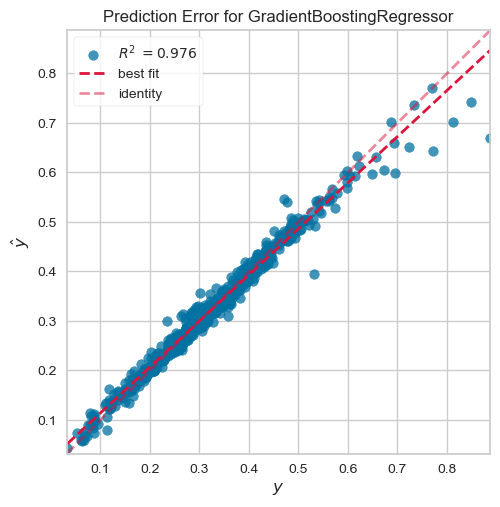

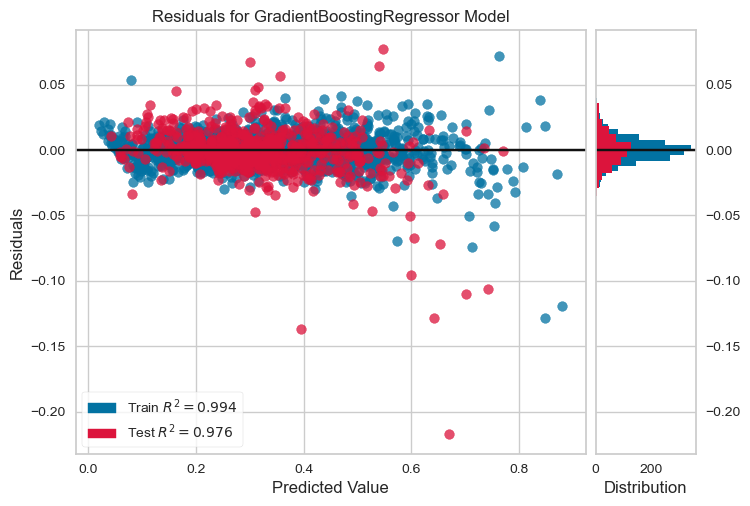

In [53]:
gb_r = GradientBoostingRegressor(learning_rate=0.08, n_estimators=80, max_depth = 7, min_samples_split=170,
                                    min_samples_leaf=6, max_features=19, subsample=0.75, random_state=42)
gb_r.fit(X, y)

y_hat_gb_r = gb_r.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mse(y_true, y_hat_gb_r)
RMSE = np.sqrt(MSE)

R_squared_gb_r = r2_score(y_true, y_hat_gb_r)

print("\nMSE: ", np.round(MSE, 4))
print()
print("R-Squared: ", np.round(R_squared_gb_r, 3))


# Making the Prediction Error Plot
prediction_error(gb_r, X, y, X_test, y_test, line_color = 'crimson')

try:
    # Making the Residuals Plot
    residuals_plot(gb_r, X, y, X_test, y_test, test_color='crimson', hist=True, qqplot=False)
except:
    raise


Text(0.5, 1.0, "GBoost's Permutation Importance of the top 20 features")

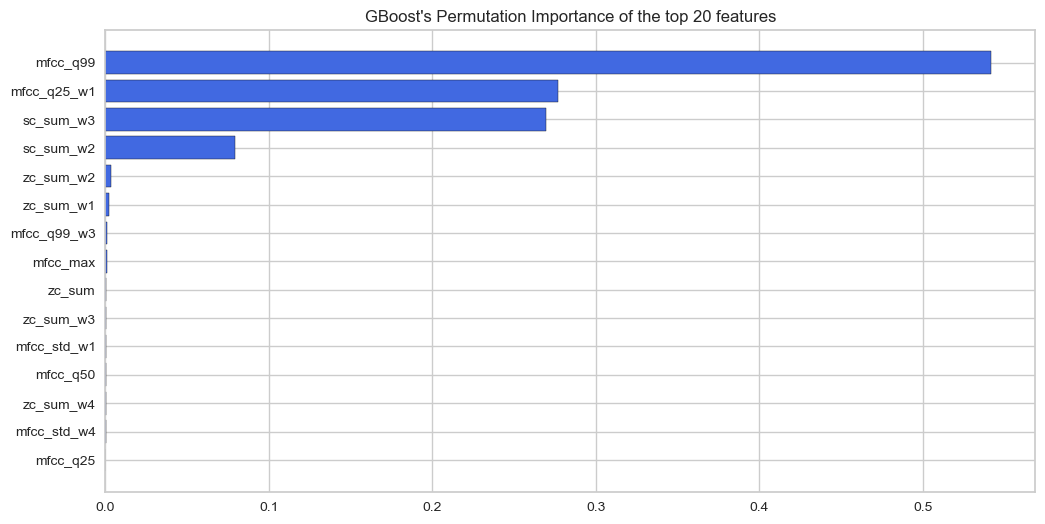

In [54]:
first_n = 20
perm_importance = permutation_importance(gb_r, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-first_n:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'GBoost\'s Permutation Importance of the top {first_n} features')

### Hist GBoost


RMSE:  0.023

R-Squared:  0.97


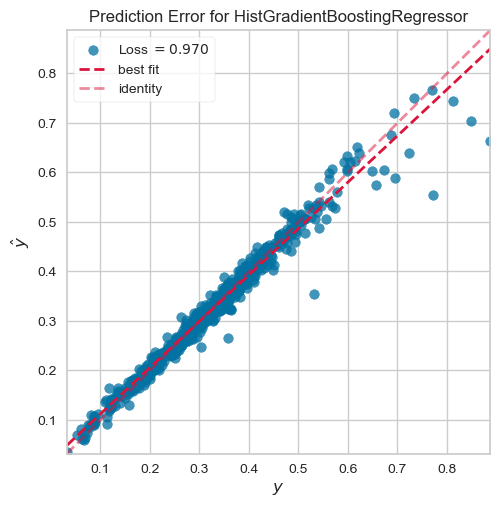

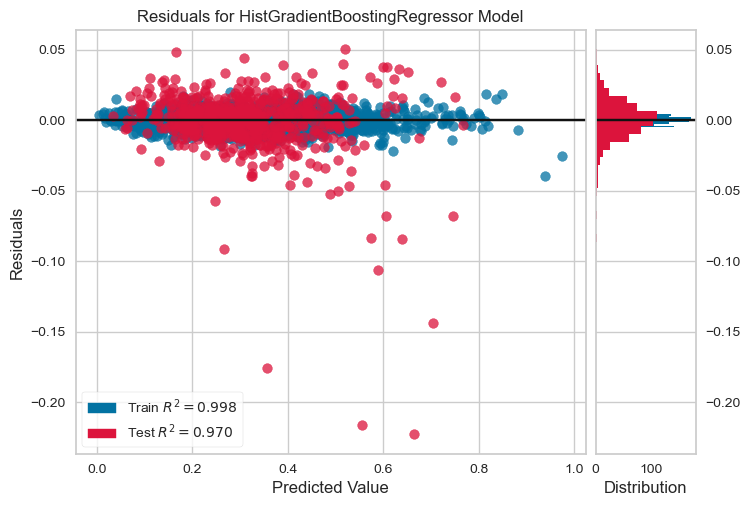

In [55]:
hgb_r = HistGradientBoostingRegressor(learning_rate=0.08, 
                                    max_depth = 7, min_samples_leaf=6,
                                    l2_regularization = 0.1, random_state=42)
hgb_r.fit(X, y)

y_hat_hgb_r = hgb_r.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mse(y_true, y_hat_hgb_r)
RMSE = np.sqrt(MSE)

R_squared_hgb_r = r2_score(y_true, y_hat_hgb_r)

print("\nRMSE: ", np.round(RMSE, 3))
print()
print("R-Squared: ", np.round(R_squared_hgb_r, 3))

# Making the Prediction Error Plot
prediction_error(hgb_r, X, y, X_test, y_test, line_color = 'crimson')

try:
    # Making the Residuals Plot
    residuals_plot(hgb_r, X, y, X_test, y_test, test_color='crimson', hist=True, qqplot=False)
except:
    raise


Text(0.5, 1.0, "HistGBoost's Permutation Importance of the top 20 features")

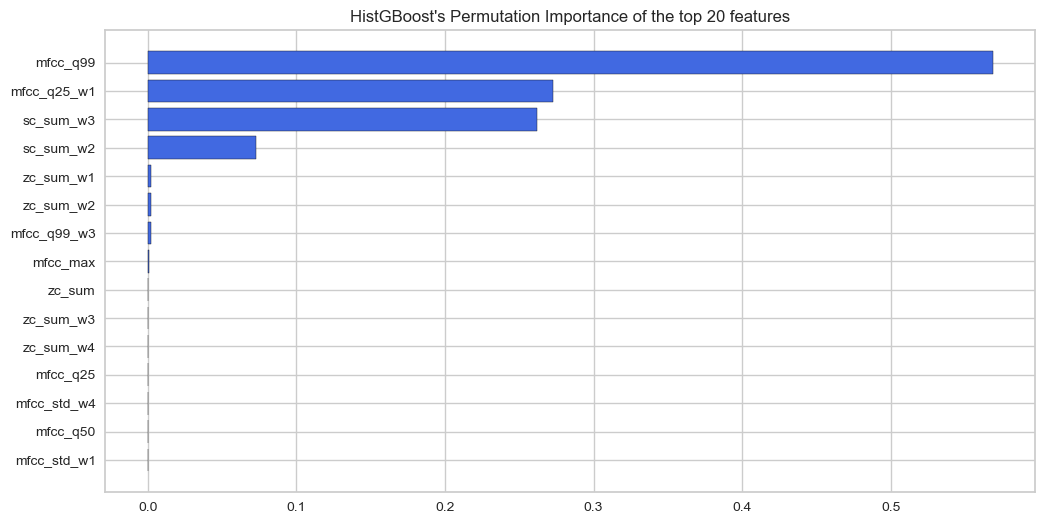

In [56]:
first_n = 20
perm_importance = permutation_importance(hgb_r, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-first_n:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'HistGBoost\'s Permutation Importance of the top {first_n} features')

### XGBoost


RMSE:  0.036

R-Squared:  0.925


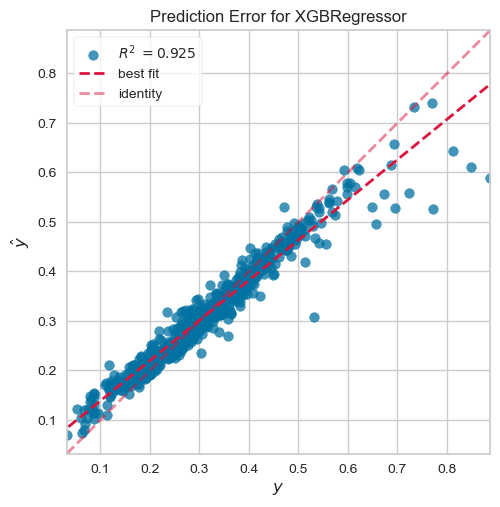

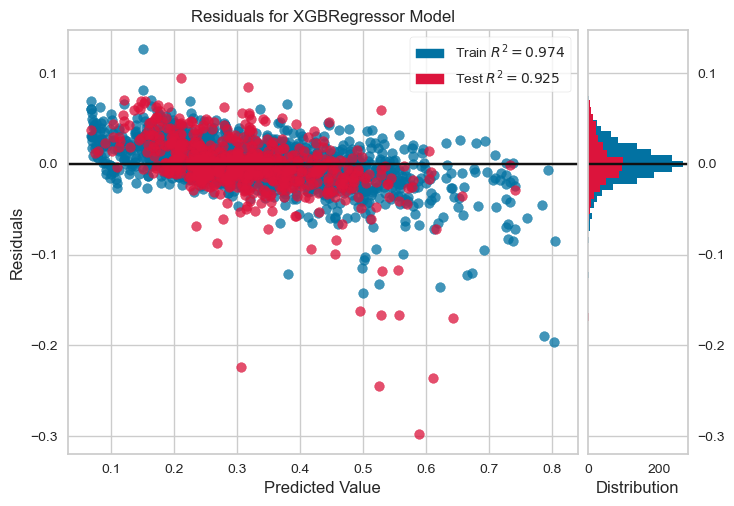

In [57]:
xgb_r = XGBRegressor(objective = 'reg:squarederror', learning_rate=0.1, n_estimators=80, 
                        max_depth = 7, reg_lambda = 0.01, tree_method='exact', random_state=42,
                        gamma = 0.1)
xgb_r.fit(X, y)

y_hat_xgb_r = xgb_r.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mse(y_true, y_hat_xgb_r)
RMSE = np.sqrt(MSE)

R_squared_xgb_r = r2_score(y_true, y_hat_xgb_r)

print("\nRMSE: ", np.round(RMSE, 3))
print()
print("R-Squared: ", np.round(R_squared_xgb_r, 3))

# Making the Prediction Error Plot
prediction_error(xgb_r, X, y, X_test, y_test, line_color = 'crimson')

try:
    # Making the Residuals Plot
    residuals_plot(xgb_r, X, y, X_test, y_test, test_color='crimson', hist=True, qqplot=False)
except:
    raise


Text(0.5, 1.0, "XGBoost's Permutation Importance of the top 20 features")

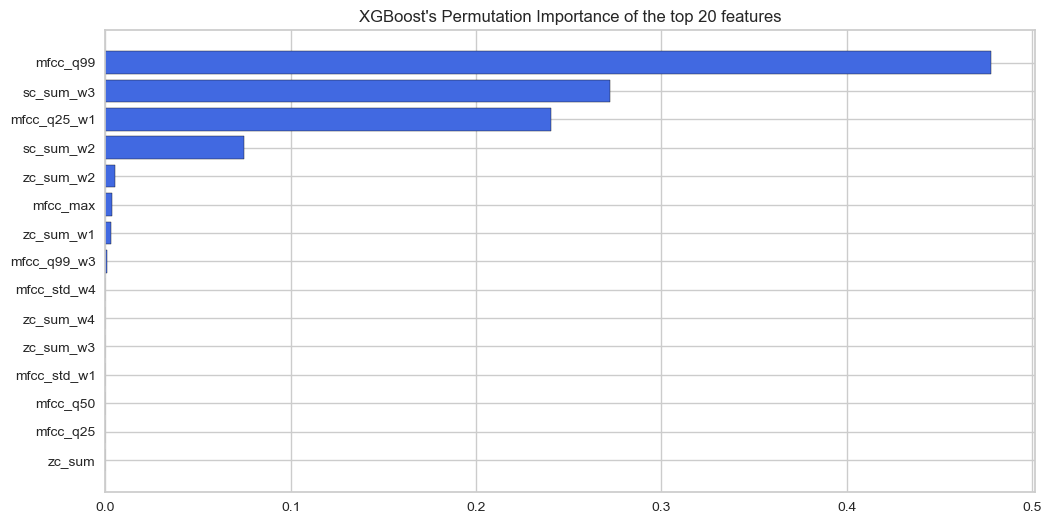

In [58]:
first_n = 20
perm_importance = permutation_importance(xgb_r, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-first_n:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'XGBoost\'s Permutation Importance of the top {first_n} features')


### Light GBM


RMSE:  0.027

R-Squared:  0.959


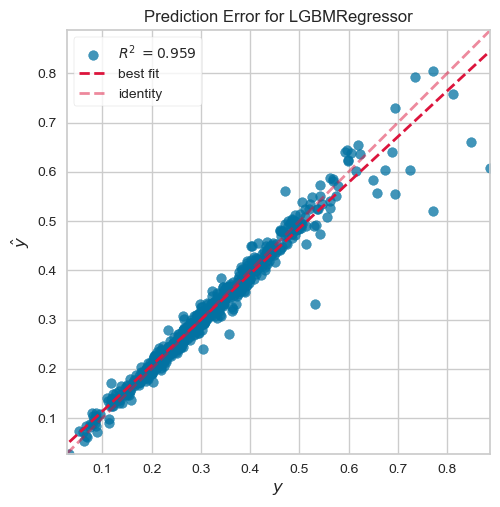

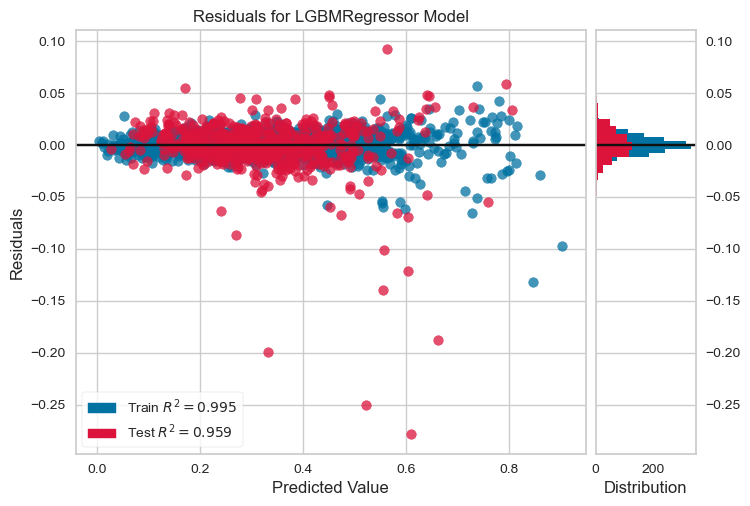

In [59]:
lgbm_r = LGBMRegressor(boosting_type='goss', 
                        learning_rate=0.1, n_estimators=80, max_depth = -1, 
                        reg_lambda = 0.01, random_state=42)

lgbm_r.fit(X, y)

y_hat_lgbm_r = lgbm_r.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mse(y_true, y_hat_lgbm_r)
RMSE = np.sqrt(MSE)

R_squared_lgbm_r = r2_score(y_true, y_hat_lgbm_r)

print("\nRMSE: ", np.round(RMSE, 3))
print()
print("R-Squared: ", np.round(R_squared_lgbm_r, 3))

# Making the Prediction Error Plot
prediction_error(lgbm_r, X, y, X_test, y_test, line_color = 'crimson')

try:
    # Making the Residuals Plot
    residuals_plot(lgbm_r, X, y, X_test, y_test, test_color='crimson', hist=True, qqplot=False)
except:
    raise

Text(0.5, 1.0, "LightGBoost's Permutation Importance of the top 20 features")

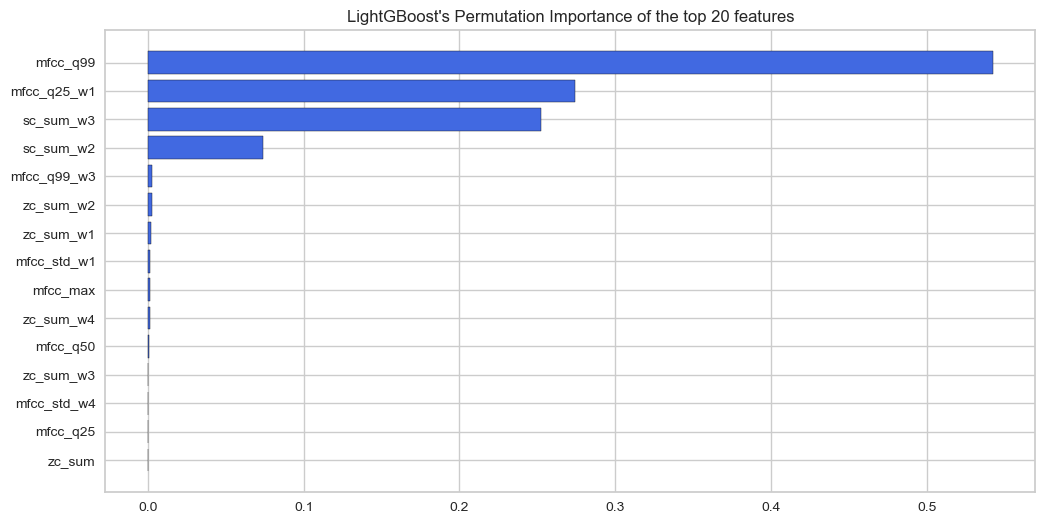

In [60]:
first_n = 20
perm_importance = permutation_importance(lgbm_r, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-first_n:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = 'royalblue', edgecolor='k')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title(f'LightGBoost\'s Permutation Importance of the top {first_n} features')